In [ ]:
!pip install PyTDC
import torch
print(torch.__version__)
!pip install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

2.4.0+cu121
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
  Using cached torch_geometric-2.5.3-py3-none-any.whl.metadata (64 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.1 MB/s eta 0:00:00


# The most important aspect: Well-curated data
## Therapeutics Data Commons: An easily accessible source
- lots of standard data sets on [tdcommons.ai](https://tdcommons.ai)
- easy data splitting (random, scaffold, cold_*)

## A solubility dataset: AqSolDB
- made by [Sorkun, Khetan, Er (2019)](https://www.nature.com/articles/s41597-019-0151-1)
- compound data set (merged 9 data sets)
- handling of duplicates and multiple measurements:
  - more than 2: select the one closest to the mean
  - 2 measurements: select the one closest to ALOGPS prediction

In [ ]:
from tdc.single_pred import ADME
data = ADME(name = 'Solubility_AqSolDB')
split = data.get_split(method='random')
data.print_stats()

Downloading...
100%|██████████| 853k/853k [00:00<00:00, 7.78MiB/s]
Loading...
Done!
--- Dataset Statistics ---
9982 unique drugs.
--------------------------


In [ ]:
split['train']

,Drug_ID,Drug,Y
0,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
1,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
2,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
3,vinyltoluene,C=Cc1cccc(C)c1,-3.123150
4,3-(3-ethylcyclopentyl)propanoic acid,CCC1CCC(CCC(=O)O)C1,-3.286116
...,...,...,...
6983,sarafloxacin,O=C(O)c1cn(-c2ccc(F)cc2)c2cc(N3CCNCC3)c(F)cc2c1=O,-3.130000
6984,sparfloxacin,C[C@H]1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c...,-3.370000
6985,sulindac_form_II,CC1=C(CC(=O)O)c2cc(F)ccc2/C1=C/c1ccc(S(C)=O)cc1,-4.500000
6986,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000


### Label distribution

<Axes: xlabel='Y', ylabel='Density'>

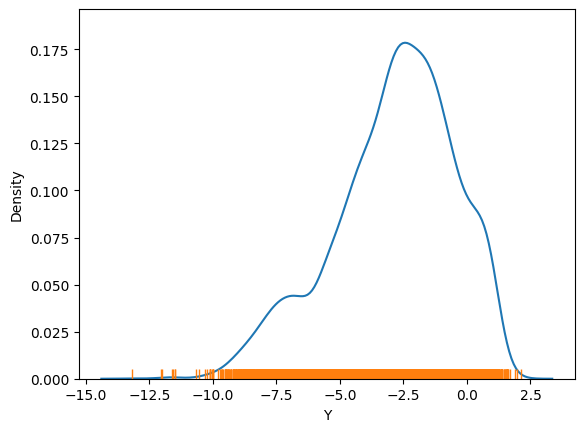

In [ ]:
import seaborn as sns
sns.kdeplot(split['train']['Y'])
sns.rugplot(split['train']['Y'])

## Featurization
- __rdkit__ is the main tool for working with molecules
- `rdFingerprintGenerator` can  produce a multitude of fingerprints

In [ ]:
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem

# Quiet rdkit warnings
RDLogger.logger().setLevel(RDLogger.CRITICAL)

In [ ]:
from rdkit.Chem import rdFingerprintGenerator
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)

We featurize the training and test set. We ignore the validation set for now.

In [ ]:
import numpy as np
import tqdm

smiles2fp = lambda smiles: mfpgen.GetFingerprintAsNumPy(Chem.MolFromSmiles(smiles))
X_train = np.stack(list(map(smiles2fp, tqdm.tqdm(split['train']['Drug']))))
y_train = split['train']['Y'].values
X_test = np.stack(list(map(smiles2fp, tqdm.tqdm(split['test']['Drug']))))
y_test = split['test']['Y'].values

100%|██████████| 1996/1996 [00:00<00:00, 2499.91it/s]


# Random forest regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Test (MSE): {mse}")

Test (MSE): 1.8208764879290724


Text(0.5, 0, 'predicted value')

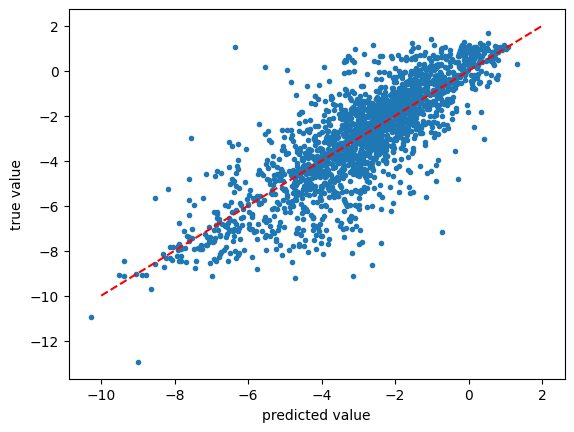

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_pred, y_test, marker='.')
plt.plot([-10, 2], [-10, 2], 'r--')
plt.ylabel('true value')
plt.xlabel('predicted value')

## Interpreting the forest

array([561, 119, 849])

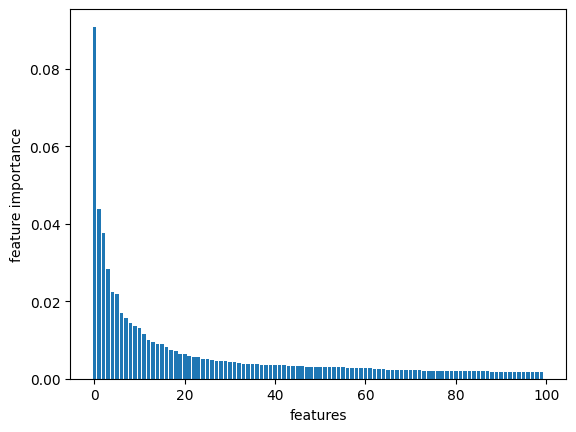

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(100), sorted(rf_model.feature_importances_, reverse=True)[:100])
plt.ylabel('feature importance')
plt.xlabel('features')
top3bits = np.argsort(rf_model.feature_importances_)[:-4:-1]
top3bits

In [ ]:
from collections import Counter

from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import AdditionalOutput
import tqdm

def get_bit_info(mol):
    info = AdditionalOutput()
    info.CollectBitInfoMap()
    mfpgen.GetFingerprintAsNumPy(mol, additionalOutput=info)

    return info.GetBitInfoMap()


def get_fragment_for_bit(mol, bitId):
    bitInfo = get_bit_info(mol)
    if bitId not in bitInfo:
        return None
    atom_indices = [info[0] for info in bitInfo[bitId]]
    env_radius = bitInfo[bitId][0][1]
    env = Chem.FindAtomEnvironmentOfRadiusN(mol, env_radius, atom_indices[0])
    submol = Chem.PathToSubmol(mol, env)

    return submol

no_rings = lambda smiles: ''.join((c.upper() if c in 'cons' else c) for c in smiles)

fragments = {k: Counter() for k in top3bits}
for smiles in tqdm.tqdm(split['train']['Drug']):
    mol = Chem.MolFromSmiles(smiles)
    for bit in top3bits:  # The three most important bits
        frag = get_fragment_for_bit(mol, bit)
        if frag is not None and frag.GetNumAtoms() > 0:
            frag = Chem.MolToSmiles(frag, canonical=True)
            fragments[bit][no_rings(frag)] += 1

100%|██████████| 6988/6988 [00:03<00:00, 1827.06it/s]


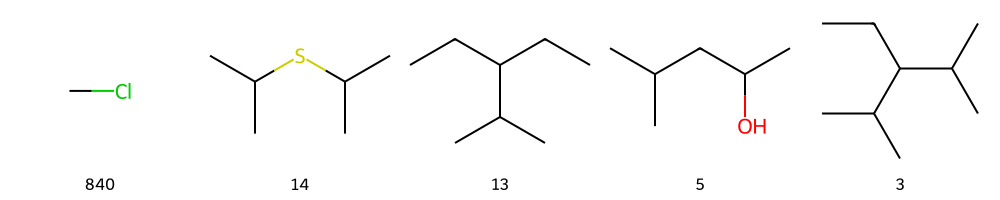

In [ ]:
molecules = fragments[top3bits[0]].most_common(5)
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol, _ in molecules], molsPerRow=5, subImgSize=(200, 200), legends=[str(c) for _, c in molecules])

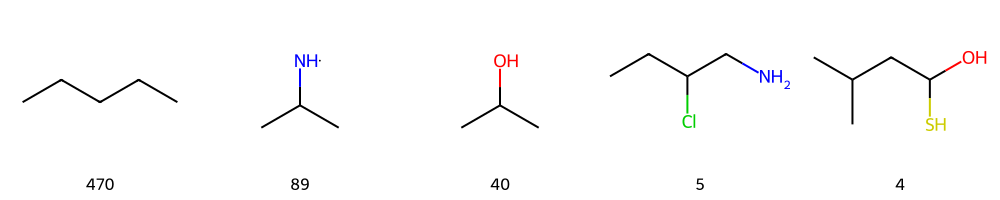

In [ ]:
molecules = fragments[top3bits[1]].most_common(5)
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol, _ in molecules], molsPerRow=5, subImgSize=(200, 200), legends=[str(c) for _, c in molecules])

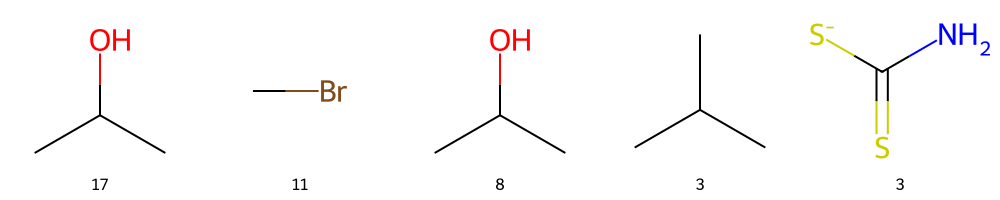

In [ ]:
molecules = fragments[top3bits[2]].most_common(5)
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol, _ in molecules], molsPerRow=5, subImgSize=(200, 200), legends=[str(c) for _, c in molecules])

# Neural networks

## Multi-layer perceptron (MLP) on fingerprints

In [ ]:
import tqdm
import torch
torch.manual_seed(0)
from torch.utils.data import Dataset, DataLoader

class SolubilityDataset(Dataset):
    def __init__(self, split):
        self.fingerprints = torch.tensor(list(map(smiles2fp, split['Drug'])), dtype=torch.float)
        self.labels = torch.tensor(split['Y'], dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        fingerprint = self.fingerprints[idx]
        label = self.labels[idx]
        return fingerprint, label

train_dataset = SolubilityDataset(split['train'])
valid_dataset = SolubilityDataset(split['valid'])
test_dataset = SolubilityDataset(split['test'])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [ ]:
import torch.nn as nn
import torch.optim as optim

class SolubilityNet(nn.Module):
    def __init__(self):
        super(SolubilityNet, self).__init__()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SolubilityNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_step(loader):
    model.train()
    total_loss = 0
    for fingerprints, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(fingerprints)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(labels)
    return total_loss / len(loader.dataset)

def test_step(loader):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for fingerprints, labels in valid_dataloader:
            outputs = model(fingerprints)
            valid_loss += criterion(outputs.squeeze(), labels).item()
    valid_loss /= len(valid_dataloader)
    return valid_loss

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_step(train_dataloader)
    valid_loss = test_step(valid_dataloader)

    print(f'Epoch: {epoch + 1:03d}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

Epoch: 001, Train Loss: 3.5182, Validation Loss: 2.3370
Epoch: 002, Train Loss: 1.9713, Validation Loss: 2.1268
Epoch: 003, Train Loss: 1.4229, Validation Loss: 1.9204
Epoch: 004, Train Loss: 1.0089, Validation Loss: 1.9456
Epoch: 005, Train Loss: 0.7054, Validation Loss: 1.8316
Epoch: 006, Train Loss: 0.5042, Validation Loss: 1.8570
Epoch: 007, Train Loss: 0.3862, Validation Loss: 1.8896
Epoch: 008, Train Loss: 0.3156, Validation Loss: 1.8227
Epoch: 009, Train Loss: 0.2729, Validation Loss: 1.8368
Epoch: 010, Train Loss: 0.2393, Validation Loss: 1.8042
Epoch: 011, Train Loss: 0.2370, Validation Loss: 1.8583
Epoch: 012, Train Loss: 0.2105, Validation Loss: 1.8014
Epoch: 013, Train Loss: 0.1945, Validation Loss: 1.8605
Epoch: 014, Train Loss: 0.1872, Validation Loss: 1.7938
Epoch: 015, Train Loss: 0.1835, Validation Loss: 1.8073
Epoch: 016, Train Loss: 0.1772, Validation Loss: 1.8630
Epoch: 017, Train Loss: 0.1702, Validation Loss: 1.7975
Epoch: 018, Train Loss: 0.1607, Validation Loss:

In [ ]:
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for fingerprints, labels in test_dataloader:
            outputs = model(fingerprints)
            test_loss += criterion(outputs.squeeze(), labels).item()
    test_loss /= len(test_dataloader)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 1.6684


Text(0.5, 0, 'predicted value')

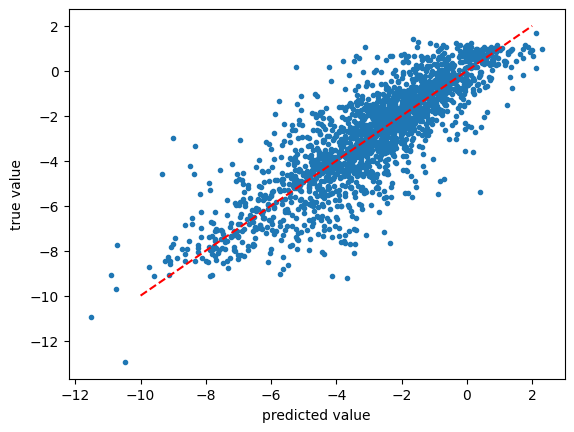

In [ ]:
with torch.no_grad():
    plt.scatter(model(test_dataloader.dataset.fingerprints).flatten(), test_dataloader.dataset.labels, marker='.')
plt.plot([-10, 2], [-10, 2], 'r--')
plt.ylabel('true value')
plt.xlabel('predicted value')

## Graph neural network (GNN)

First, we need to create graph structures out of the SMILES string. For this, we use the from_smiles utility in pytorch-geometric. This way, we create one `Data` object for each molecule. We additionally annotate each molecule with the solubility value (as attribute `y`).

In [ ]:
from torch_geometric.utils import from_smiles
from torch_geometric.loader import DataLoader

def process_smiles(row):
    data = from_smiles(row.Drug)
    data.x = data.x.to(torch.float)
    data.y = torch.tensor(row.Y, dtype=torch.float)
    return data

train_dataloader = DataLoader(list(map(process_smiles, split['train'].itertuples())), batch_size=32, shuffle=True)
valid_dataloader = DataLoader(list(map(process_smiles, split['valid'].itertuples())), batch_size=32)
test_dataloader = DataLoader(list(map(process_smiles, split['test'].itertuples())), batch_size=32)

Let's take a look at an example molecule and its pytorch-geometric encoding.

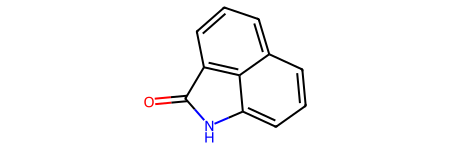

In [ ]:
smiles = split['train']['Drug'][0]
Chem.MolFromSmiles(smiles)

This graph is represented as a `Data` object. The nodes and its features are stored in `x` with shape `(n_nodes, n_features)`. The bond structure is given as an adjacency list in `edge_index`. Edge features can be found in `edge_attr`.

In [ ]:
data = from_smiles(split['train']['Drug'][0])
data

Data(x=[13, 9], edge_index=[2, 30], edge_attr=[30, 3], smiles='O=C1Nc2cccc3cccc1c23')

The atom featurization uses some basic features with torch-geometric computes using rdkit.

In [ ]:
# excerpt from torch_geometrics molecular featurization

# for atom in mol.GetAtoms():
#     row: List[int] = []
#     row.append(x_map['atomic_num'].index(atom.GetAtomicNum()))
#     row.append(x_map['chirality'].index(str(atom.GetChiralTag())))
#     row.append(x_map['degree'].index(atom.GetTotalDegree()))
#     row.append(x_map['formal_charge'].index(atom.GetFormalCharge()))
#     row.append(x_map['num_hs'].index(atom.GetTotalNumHs()))
#     row.append(x_map['num_radical_electrons'].index(atom.GetNumRadicalElectrons()))
#     row.append(x_map['hybridization'].index(str(atom.GetHybridization())))
#     row.append(x_map['is_aromatic'].index(atom.GetIsAromatic()))
#     row.append(x_map['is_in_ring'].index(atom.IsInRing()))
#     xs.append(row)

data.x

tensor([[8, 0, 1, 5, 0, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 0, 1],
        [7, 0, 3, 5, 1, 0, 3, 0, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1]])

In [ ]:
from torch_geometric.nn import global_mean_pool, GCNConv


import torch
import torch.nn.functional as Fun
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU

from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool

import torch.nn.functional as Fun



class GIN(torch.nn.Module):
    """Graph Isomorphism Network class with 3 GINConv layers and 2 linear layers"""

    def __init__(self, dim_h):
        """Initializing GIN class

        Args:
            dim_h (int): the dimension of hidden layers
        """
        super(GIN, self).__init__()

        self.conv1 = GINConv(
            Sequential(Linear(9, dim_h), ReLU(), Linear(dim_h, dim_h), ReLU())
        )
        self.conv2 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.conv3 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )

        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        # Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        h = global_add_pool(h, batch)

        h = self.lin1(h)
        h = h.relu()
        h = Fun.dropout(h, p=0.1, training=self.training)
        h = self.lin2(h)

        return h

model = GIN(32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train():
    model.train()
    total_loss = 0
    for data in train_dataloader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_dataloader.dataset)

def test(loader):
    model.eval()
    total_loss = 0
    for data in loader:
        out = model(data)
        loss = criterion(out.squeeze(), data.y)
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

for epoch in range(50):
    train_loss = train()
    valid_loss = test(valid_dataloader)
    print(f'Epoch: {epoch + 1:03d}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

Epoch: 001, Train Loss: 5.9519, Validation Loss: 6.1411
Epoch: 002, Train Loss: 5.4683, Validation Loss: 5.6694
Epoch: 003, Train Loss: 4.8367, Validation Loss: 4.8218
Epoch: 004, Train Loss: 4.4758, Validation Loss: 4.7422
Epoch: 005, Train Loss: 4.0241, Validation Loss: 4.3780
Epoch: 006, Train Loss: 3.8730, Validation Loss: 3.8402
Epoch: 007, Train Loss: 3.8734, Validation Loss: 3.7370
Epoch: 008, Train Loss: 4.0748, Validation Loss: 3.9763
Epoch: 009, Train Loss: 3.8175, Validation Loss: 3.8092
Epoch: 010, Train Loss: 3.5890, Validation Loss: 3.1991
Epoch: 011, Train Loss: 3.4917, Validation Loss: 3.1230
Epoch: 012, Train Loss: 3.4924, Validation Loss: 3.7034
Epoch: 013, Train Loss: 3.4441, Validation Loss: 3.2163
Epoch: 014, Train Loss: 3.3368, Validation Loss: 3.0299
Epoch: 015, Train Loss: 3.1177, Validation Loss: 2.7136
Epoch: 016, Train Loss: 3.2747, Validation Loss: 2.8890
Epoch: 017, Train Loss: 3.0031, Validation Loss: 2.8214
Epoch: 018, Train Loss: 2.9617, Validation Loss:

In [ ]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for data in test_dataloader:
        outputs = model(data)
        test_loss += criterion(outputs.squeeze(), data.y).item()
test_loss /= len(test_dataloader)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 1.7596


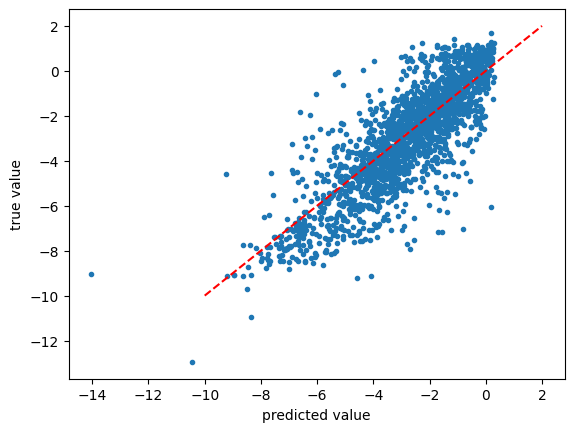

In [ ]:
with torch.no_grad():
  predictions, ground_truth = list(), list()
  for data in test_dataloader:
      outputs = model(data)
      predictions.extend(list(outputs.squeeze()))
      ground_truth.extend(list(data.y))
plt.scatter(predictions, ground_truth, marker='.')
plt.ylabel('true value')
plt.xlabel('predicted value')
plt.plot([-10, 2], [-10, 2], 'r--')

Missing aspects / points to improve / explore:
- cross-validation instead of single point estimates
- MAE for test error quantification
- explainability of NN models